# Build QP SNR2 Weights From Template + PSD

This notebook generates one-sided SNR2 weights for EMPCA training using consistent PSD units:

`snr2(f) = template_psd(f) / (noise_psd(f) + eps)`

where `template_psd` is computed with `reusable/PSDCalculator.py` after baseline subtraction.


In [1]:
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt


def _repo_root():
    here = Path.cwd().resolve()
    cands = [here, here.parent, here.parent.parent]
    for c in cands:
        if (c / 'wk4').exists() and (c / 'reusable').exists():
            return c
        if (c / 'PCA_dev' / 'wk4').exists() and (c / 'PCA_dev' / 'reusable').exists():
            return c / 'PCA_dev'
    raise RuntimeError('Run from DELight_mtr, PCA_dev, or PCA_dev/wk4/make_template')


repo = _repo_root()
reusable_dir = repo / 'reusable'
if str(reusable_dir) not in sys.path:
    sys.path.insert(0, str(reusable_dir))

from PSDCalculator import calculate_psd

print('repo =', repo)


repo = /home/dwong/DELight_mtr/PCA_dev


In [2]:
# Config
TEMPLATE_PATH = repo / 'wk4' / 'make_template' / 'outputs' / 'QP_template_smooth.npy'
CONFIG_PATH = repo / 'reusable' / 'PCA_config.yaml'
BASELINE_SAMPLES = 2000


def _load_simple_yaml(path: Path):
    data = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            s = line.strip()
            if not s or s.startswith('#') or ':' not in s:
                continue
            k, v = s.split(':', 1)
            k = k.strip()
            v = v.strip().strip('"').strip("'")
            # try int/float parse, else keep string
            try:
                if any(ch in v for ch in ['.', 'e', 'E']):
                    data[k] = float(v)
                else:
                    data[k] = int(v)
                continue
            except Exception:
                data[k] = v
    return data


# Prefer PyYAML when available; fallback parser handles this flat config file.
try:
    import yaml  # type: ignore
    with open(CONFIG_PATH, 'r', encoding='utf-8') as f:
        cfg = yaml.safe_load(f)
except Exception:
    cfg = _load_simple_yaml(CONFIG_PATH)

if 'sampling_frequency' not in cfg:
    raise KeyError(f"sampling_frequency not found in {CONFIG_PATH}")

SAMPLING_FREQUENCY_HZ = float(cfg['sampling_frequency'])
EPS = 1e-18

REUSABLE_WEIGHT_DIR = repo / 'reusable' / 'weight'
REUSABLE_WEIGHT_DIR.mkdir(parents=True, exist_ok=True)

NOISE_CONFIGS = {
    'mmc': {
        'psd': Path('/ceph/dwong/delight/noise_psd_xray.npy'),
        'snr2_out': REUSABLE_WEIGHT_DIR / 'qp_snr2_weight_MMC.npy',
    },
    'white': {
        'psd': REUSABLE_WEIGHT_DIR / 'noise_psd_white.npy',
        'snr2_out': REUSABLE_WEIGHT_DIR / 'qp_snr2_weight_white.npy',
    },
    'pink': {
        'psd': REUSABLE_WEIGHT_DIR / 'noise_psd_pink.npy',
        # Keep filename aligned with current training config (uses qo_* for pink)
        'snr2_out': REUSABLE_WEIGHT_DIR / 'qo_snr2_weight_pink.npy',
    },
}

print('config path:', CONFIG_PATH)
print('sampling_frequency_hz:', SAMPLING_FREQUENCY_HZ)
print('baseline_samples:', BASELINE_SAMPLES)


config path: /home/dwong/DELight_mtr/PCA_dev/reusable/PCA_config.yaml
sampling_frequency_hz: 3906250.0
baseline_samples: 2000


In [3]:
def load_psd_1d(path: Path):
    arr = np.load(path)
    arr = np.asarray(arr)
    freq = None
    if arr.ndim == 2 and arr.shape[0] == 2:
        freq = np.asarray(arr[0], dtype=np.float64)
        arr = arr[1]
    if arr.ndim != 1:
        raise ValueError(f'PSD must be 1D or shape (2, n). Got {arr.shape} from {path}')
    return freq, arr.astype(np.float64)


def calculate_template_psd(template, fs_hz=1.0):
    template = np.asarray(template, dtype=np.float64).squeeze()
    if template.ndim != 1:
        raise ValueError(f'template must be 1D; got {template.shape}')
    freq, template_psd = calculate_psd(template, sampling_frequency=float(fs_hz))
    return np.asarray(freq, dtype=np.float64), np.asarray(template_psd, dtype=np.float64)


def build_snr2_weight(template_psd, noise_psd, eps=1e-18):
    template_psd = np.asarray(template_psd, dtype=np.float64).squeeze()
    psd = np.asarray(noise_psd, dtype=np.float64).squeeze()

    if template_psd.ndim != 1:
        raise ValueError(f'template_psd must be 1D; got {template_psd.shape}')
    if psd.ndim != 1:
        raise ValueError(f'noise_psd must be 1D; got {psd.shape}')
    if template_psd.shape[0] != psd.shape[0]:
        raise ValueError(
            f'Length mismatch: template PSD has {template_psd.shape[0]} bins, PSD has {psd.shape[0]} bins'
        )

    snr2 = template_psd / (psd + float(eps))
    # Keep metric valid for weighted projection
    snr2 = np.clip(snr2, 0.0, None)
    return snr2


In [4]:
template_raw = np.load(TEMPLATE_PATH).astype(np.float64).squeeze()
if template_raw.ndim != 1:
    raise ValueError(f'Template must be 1D; got {template_raw.shape}')
if template_raw.shape[0] < BASELINE_SAMPLES:
    raise ValueError(f'Template is shorter than baseline window: {template_raw.shape[0]} < {BASELINE_SAMPLES}')

baseline = template_raw[:BASELINE_SAMPLES]
baseline_mean = float(np.mean(baseline))
baseline_std = float(np.std(baseline))
template = template_raw - baseline_mean

freq, template_psd = calculate_template_psd(template, fs_hz=SAMPLING_FREQUENCY_HZ)

print('template path:', TEMPLATE_PATH)
print('template n_samples:', template.shape[0])
print('expected rfft bins:', template.shape[0] // 2 + 1)
print('baseline[0:200] mean:', baseline_mean)
print('baseline[0:200] std :', baseline_std)


template path: /home/dwong/DELight_mtr/PCA_dev/wk4/make_template/outputs/QP_template_smooth.npy
template n_samples: 32768
expected rfft bins: 16385
baseline[0:200] mean: -3.0256707047454643e-10
baseline[0:200] std : 3.84473965603581e-05


In [5]:
saved = {}
summary = {}
noise_psd_by_name = {}
snr2_by_name = {}

for noise_name, cfg in NOISE_CONFIGS.items():
    psd_path = cfg['psd']
    out_path = cfg['snr2_out']

    if not psd_path.exists():
        raise FileNotFoundError(f'PSD not found for {noise_name}: {psd_path}')

    psd_freq, psd = load_psd_1d(psd_path)
    snr2 = build_snr2_weight(
        template_psd=template_psd,
        noise_psd=psd,
        eps=EPS,
    )

    np.save(out_path, snr2)
    saved[noise_name] = str(out_path)
    noise_psd_by_name[noise_name] = psd
    snr2_by_name[noise_name] = snr2

    psd_freq_max_abs_diff = None
    if psd_freq is not None and psd_freq.shape[0] == freq.shape[0]:
        psd_freq_max_abs_diff = float(np.max(np.abs(psd_freq - freq)))

    summary[noise_name] = {
        'psd_path': str(psd_path),
        'snr2_path': str(out_path),
        'n_bins': int(snr2.shape[0]),
        'psd_min': float(np.min(psd)),
        'psd_median': float(np.median(psd)),
        'psd_max': float(np.max(psd)),
        'min': float(np.min(snr2)),
        'median': float(np.median(snr2)),
        'max': float(np.max(snr2)),
        'q99': float(np.quantile(snr2, 0.99)),
        'psd_freq_max_abs_diff_vs_rfftfreq': psd_freq_max_abs_diff,
    }

print('saved paths:')
for k, v in saved.items():
    print(f'  {k}: {v}')

print('\nsummary stats:')
for k, v in summary.items():
    print(f"  {k}: SNR2 min={v['min']:.3e}, median={v['median']:.3e}, q99={v['q99']:.3e}, max={v['max']:.3e}")


saved paths:
  mmc: /home/dwong/DELight_mtr/PCA_dev/reusable/weight/qp_snr2_weight_MMC.npy
  white: /home/dwong/DELight_mtr/PCA_dev/reusable/weight/qp_snr2_weight_white.npy
  pink: /home/dwong/DELight_mtr/PCA_dev/reusable/weight/qo_snr2_weight_pink.npy

summary stats:
  mmc: SNR2 min=2.907e-09, median=2.132e-08, q99=6.205e-06, max=1.324e+00
  white: SNR2 min=2.715e-09, median=1.086e-08, q99=2.149e-05, max=1.070e+02
  pink: SNR2 min=2.634e-08, median=5.269e-08, q99=2.107e-06, max=6.338e-02


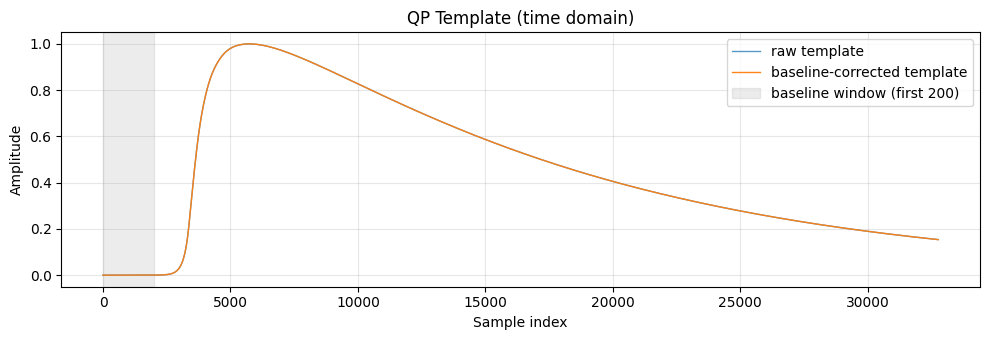

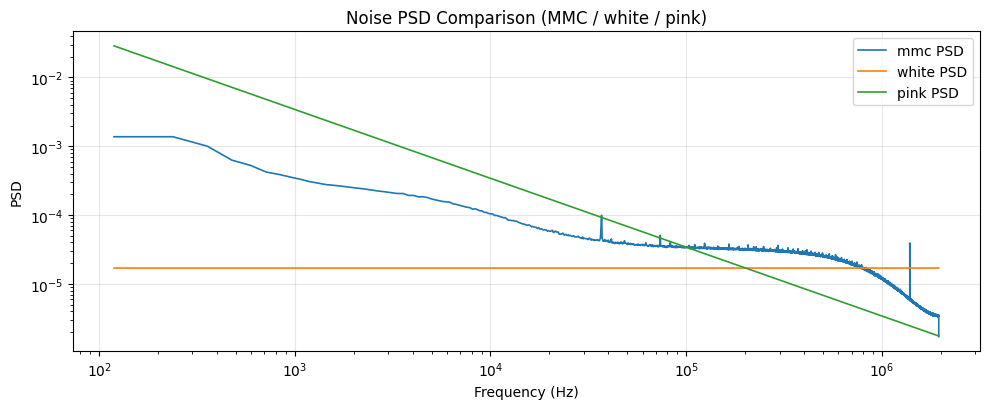

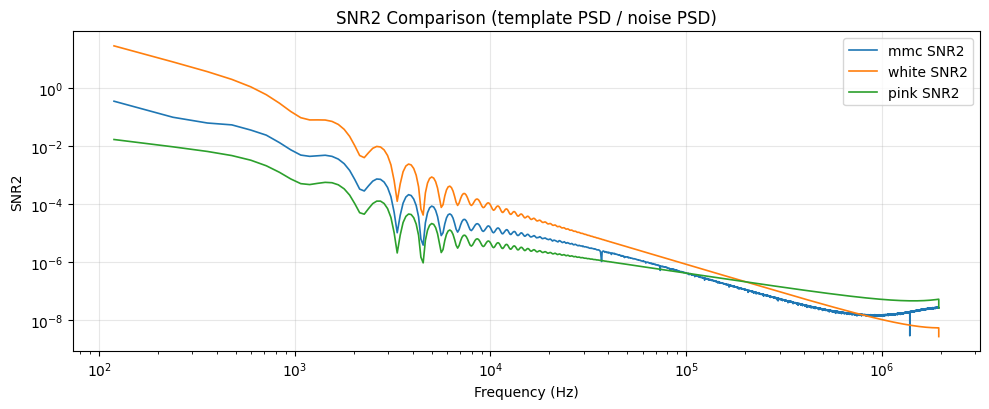

In [6]:
# 1) QP template plot (raw + baseline corrected)
fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
ax.plot(template_raw, lw=1.0, alpha=0.75, label='raw template')
ax.plot(template, lw=1.0, alpha=0.95, label='baseline-corrected template')
ax.axvspan(0, BASELINE_SAMPLES - 1, color='gray', alpha=0.15, label='baseline window (first 200)')
ax.set_title('QP Template (time domain)')
ax.set_xlabel('Sample index')
ax.set_ylabel('Amplitude')
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

# 2) One plot for three PSDs (same axes)
fig, ax = plt.subplots(1, 1, figsize=(10, 4.2))
for noise_name in NOISE_CONFIGS:
    psd = noise_psd_by_name[noise_name]
    ax.loglog(freq[1:], np.maximum(psd[1:], EPS), lw=1.2, label=f'{noise_name} PSD')
ax.set_title('Noise PSD Comparison (MMC / white / pink)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD')
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

# 3) One plot for three SNR2 curves: template_psd / noise_psd
fig, ax = plt.subplots(1, 1, figsize=(10, 4.2))
for noise_name in NOISE_CONFIGS:
    snr2 = snr2_by_name[noise_name]
    ax.loglog(freq[1:], np.maximum(snr2[1:], EPS), lw=1.2, label=f'{noise_name} SNR2')
ax.set_title('SNR2 Comparison (template PSD / noise PSD)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('SNR2')
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


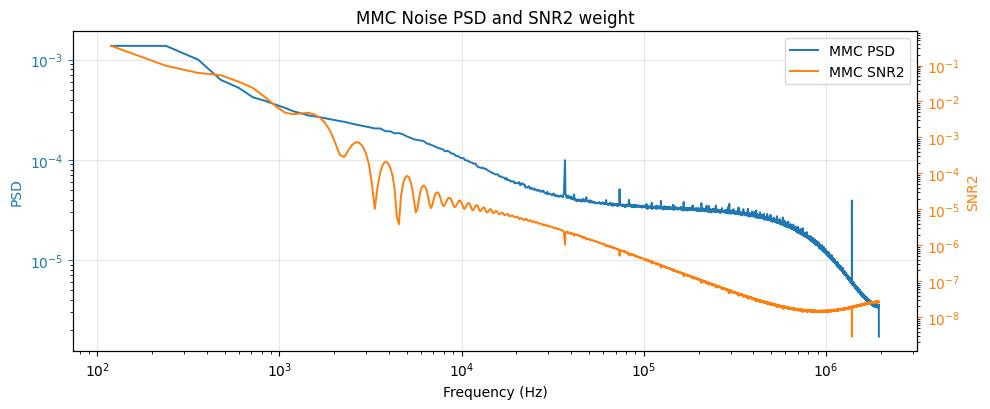

In [8]:
# 4) MMC only: noise PSD and SNR2 on one figure with dual y-axes
mmc_psd = noise_psd_by_name['mmc']
mmc_snr2 = snr2_by_name['mmc']

fig, ax_psd = plt.subplots(1, 1, figsize=(10, 4.2))
ax_snr = ax_psd.twinx()

color_psd = 'tab:blue'
color_snr = 'tab:orange'

ax_psd.loglog(freq[1:], np.maximum(mmc_psd[1:], EPS), color=color_psd, lw=1.4, label='MMC PSD')
ax_snr.loglog(freq[1:], np.maximum(mmc_snr2[1:], EPS), color=color_snr, lw=1.4, label='MMC SNR2')

ax_psd.set_title('MMC Noise PSD and SNR2 weight')
ax_psd.set_xlabel('Frequency (Hz)')
ax_psd.set_ylabel('PSD', color=color_psd)
ax_snr.set_ylabel('SNR2', color=color_snr)
ax_psd.tick_params(axis='y', colors=color_psd)
ax_snr.tick_params(axis='y', colors=color_snr)
ax_psd.grid(alpha=0.3)

lines1, labels1 = ax_psd.get_legend_handles_labels()
lines2, labels2 = ax_snr.get_legend_handles_labels()
ax_psd.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.tight_layout()
plt.show()


In [8]:
# Optional: save a build metadata file next to template outputs
import json

meta = {
    'template_path': str(TEMPLATE_PATH),
    'sampling_frequency_hz': float(SAMPLING_FREQUENCY_HZ),
    'eps': float(EPS),
    'baseline_samples': int(BASELINE_SAMPLES),
    'baseline_mean': float(baseline_mean),
    'baseline_std': float(baseline_std),
    'snr2_formula': 'template_psd/(noise_psd+eps)',
    'saved': saved,
    'summary': summary,
}

meta_path = repo / 'wk4' / 'make_template' / 'outputs' / 'QP_snr2_weight_build_meta.json'
meta_path.parent.mkdir(parents=True, exist_ok=True)
with open(meta_path, 'w', encoding='utf-8') as f:
    json.dump(meta, f, indent=2)

print('wrote metadata:', meta_path)


wrote metadata: /home/dwong/DELight_mtr/PCA_dev/wk4/make_template/outputs/QP_snr2_weight_build_meta.json
